In [1]:
import os
import copy
import numpy as np
from CT import construct_CT_object
import os
import json
import glob
import random


In [54]:

def get_path_structures_DICOM_file(path_CT_DICOM_series):
    filenames = [filename for filename in os.listdir(path_CT_DICOM_series) if filename.startswith('RS')]
    print(filenames)

    assert len(filenames) > 0, "no structures DICOM file found"
    assert len(filenames) <= 1, "more than one structures DICOM files found"

    return os.path.join(path_CT_DICOM_series, filenames[0])



root_patient = "/data/oosterhoff/patients/DBP_OP007/"
name_fixed_CT = 'pCTp0'
name_moving_CT = 'rCTp12'

path_fixed_CT = os.path.join(root_patient, name_fixed_CT, '')
path_moving_CT = os.path.join(root_patient, name_moving_CT, '')


path_struct_fixed_CT = get_path_structures_DICOM_file(path_fixed_CT)
path_struct_moving_CT = get_path_structures_DICOM_file(path_moving_CT)



fixed_CT = construct_CT_object(name_fixed_CT, path_fixed_CT, path_struct_fixed_CT, roi_names = ['External'])
moving_CT = construct_CT_object(name_moving_CT, path_moving_CT, path_struct_moving_CT, roi_names = ['External'])


['RS1.2.752.243.1.1.20231023162615444.5100.26245.dcm']
['RS1.2.752.243.1.1.20231023162615448.5700.77506.dcm']


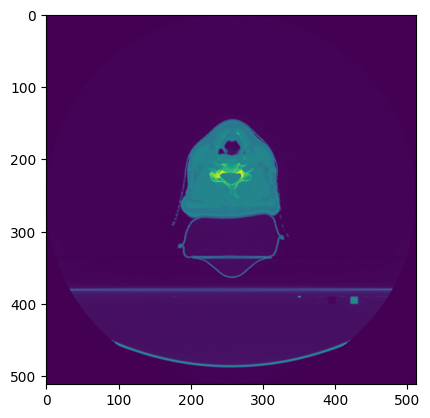

In [3]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
fixed_CT_array = sitk.GetArrayFromImage(fixed_CT.image)
moving_CT_array = sitk.GetArrayFromImage(moving_CT.image)
plt.imshow(fixed_CT_array[80])

In [58]:
class RawDataReader:
    def __init__(self, file_path):
        with open(file_path, 'r') as file:
            self.data = json.load(file)
        
        self.id = self.data['patient_id']
        self.plan_details = self.extract_plan_details()

    def extract_plan_details(self):
        plan_details = []

        # We are intrested only in examination part of the json file.
        for exam_name, exam_details in self.data['examinations'].items():
            # Initialize a dictionary to hold details for this examination
            # print(exam_details)
            if 'pCT' not in exam_name:
                # print(exam_details)
                # if 'P' not in exam_details
                exam_dict = {'exam_name': exam_name}
                # Check if 'registration_to_planning_examinations' exists for this exam
                reg_to_planning = exam_details['registration_to_planning_examinations']
                # print(reg_to_planning)
                # if 'P' not in reg_to_planning :
                for plan_name, registration_details in reg_to_planning.items():
                    if 'F' not in plan_name:
                        # print(plan_name)
                    # Retrieve the rigid_transformation_matrix if it exists
                        rigid_matrix = registration_details.get('rigid_transformation_matrix', [])
                        # rigid_matrix = registration_details['rigid_transformation_matrix']
                        # transformed_matrix = self.transform_matrix(rigid_matrix, exam_name, registration_details['to_examination_name'])
                        # print(transformed_matrix)
                        # print(rigid_matrix)
                        # print("-------------------------------")
                        if rigid_matrix:
                            exam_dict[plan_name] = {'rigid_transformation_matrix': rigid_matrix}
                
                # Append the details of this examination to the list
                if exam_dict:
                    plan_details.append(exam_dict)

        return plan_details

    def get_plan_details(self):
        return self.plan_details
    

    def transform_matrix(self, original_matrix, exam_name, to_exam_name):
        matrix = copy.deepcopy(original_matrix)
        for idx in [3, 7, 11]:
            matrix[idx] *= 10  # Convert from cm to mm
        matrix = np.array(matrix).reshape(4, 4)
        moving_CT.transform(matrix, fixed_CT)


        fixed_CT.override_air_outside_external()
        moving_CT.override_air_outside_external()

        fixed_CT.save('/data/shahpouriz/DBP_CTs/DBP_OP007/pCTp0/', save_struct_file = False)
        moving_CT.save('/data/shahpouriz/DBP_CTs/DBP_OP007/rCTp12/', save_struct_file = False)
        # fixed_CT_array = sitk.GetArrayFromImage(fixed_CT.image)
        # moving_CT_array = sitk.GetArrayFromImage(moving_CT.image)
        # plt.imshow((moving_CT_array - fixed_CT_array)[70])
        return matrix


# Usage example
case_data_path = "/home/shahpouriz/Data/DBP_CTs/DBP_OP011_case_data.json"
# name_fixed_CT = 'pCTp0'
# name_moving_CT = 'rCTp12'
treatment_data = RawDataReader(case_data_path)

plan_details = treatment_data.get_plan_details()
print(plan_details)


[{'exam_name': 'rCTp2', 'A1PHH': {'rigid_transformation_matrix': [0.9999125126947526, 0.008456565735157283, 0.010171207029322265, 0.15458265523351664, -0.008517503667256511, 0.9999459465312176, 0.0059628975394039755, -12.36475084632106, -0.01012023160528665, -0.0060490091547394645, 0.9999304927846241, -0.012613701023274193, 0.0, 0.0, 0.0, 1.0]}, 'AAPHH': {'rigid_transformation_matrix': [0.9998409462345665, 0.013784581262291564, 0.011316693518430891, 0.05165695889923247, -0.014001784835507201, 0.9997148440179957, 0.01934375019210325, -0.11574102228388838, -0.011046820999137088, -0.019499127403492036, 0.9997488443485771, 0.014134075590450962, 0.0, 0.0, 0.0, 1.0]}}, {'exam_name': 'rCTp7', 'A1PHH': {'rigid_transformation_matrix': [0.9999927202853826, -0.0025300082167756363, 0.002856297369611995, 0.21013420222301976, 0.002532341505267032, 0.9999964626673842, -0.0008135718896883113, -12.290749635930329, -0.0028542289223723, 0.0008207990874975871, 0.9999955898233336, 0.03265939828993071, 0.0,

In [34]:
import copy
import numpy as np

class RawDataReader:
    def __init__(self, file_path):
        with open(file_path, 'r') as file:
            self.data = json.load(file)
        
        self.id = self.data['patient_id']
        self.plan_details = self.extract_plan_details()

    def extract_plan_details(self):
        plan_details = []

        # We are intrested only in examination part of the json file.
        for exam_name, exam_details in self.data['examinations'].items():
            # Initialize a dictionary to hold details for this examination
            # print(exam_details)
            if 'pCT' not in exam_name:
                # print(exam_details)
                # if 'P' not in exam_details
                exam_dict = {'exam_name': exam_name}
                # Check if 'registration_to_planning_examinations' exists for this exam
                reg_to_planning = exam_details['registration_to_planning_examinations']


                for plan_name, registration_details in reg_to_planning.items():
                    if 'F' not in plan_name:
                        # print(plan_name)
                    # Retrieve the rigid_transformation_matrix if it exists
                        # rigid_matrix = registration_details.get('rigid_transformation_matrix', [])

                        rigid_matrix = registration_details['rigid_transformation_matrix']
                        transformed_matrix = self.transform_matrix(rigid_matrix, exam_name, registration_details['to_examination_name'])
                        # Here you would proceed with using the transformed_matrix, e.g., storing it
                        # For the sake of example, let's just print it
                        # print(f"Transformed matrix for {exam_name} to {registration_details['to_examination_name']}:", transformed_matrix)

        return plan_details

    def transform_matrix(self, original_matrix, exam_name, to_exam_name):
        matrix = copy.deepcopy(original_matrix)
        for idx in [3, 7, 11]:
            matrix[idx] *= 10  # Convert from cm to mm
        matrix = np.array(matrix).reshape(4, 4)
        
        # Inverting the matrix if the current exam matches the target examination name
        if exam_name == to_exam_name:
            matrix = np.linalg.inv(matrix)
            moving_CT.transform(matrix, fixed_CT)


            fixed_CT.override_air_outside_external()
            moving_CT.override_air_outside_external()

            # fixed_CT.save("", save_struct_file = False)
            # moving_CT.save("", save_struct_file = False)
        
        return matrix
    

    def get_plan_details(self):
        return self.plan_details

# Usage example
case_data_path = "/home/shahpouriz/Data/DBP_CTs/DBP_OP011_case_data.json"
treatment_data = RawDataReader(case_data_path)

plan_details = treatment_data.get_plan_details()
print(plan_details)


[]


In [ ]:
# transformation_matrix = [
#                         0.9998813462333056,
#                         0.015269076566525777,
#                         -0.002036849399907398,
#                         0.4487213396786764,
#                         -0.01531200129301428,
#                         0.999616966465917,
#                         -0.023053480645674963,
#                         -11.862892854566496,
#                         0.0016840638571796252,
#                         0.023081933504005992,
#                         0.9997321582677241,
#                         0.1085704794000017,
#                         0,
#                         0,
#                         0,
#                         1
#                     ]




transformation_matrix = copy.deepcopy(original_FoR_registration['rigid_transformation_matrix'])
for idx in [3, 7, 11]:
    transformation_matrix[idx] *= 10 # to go from cm to mm
transformation_matrix = np.array(transformation_matrix).reshape(4,4)
# if exam_name == original_FoR_registration['to_examination_name']:
#     transformation_matrix = np.linalg.inv(transformation_matrix)
moving_CT.transform(transformation_matrix, fixed_CT)


fixed_CT.override_air_outside_external()
moving_CT.override_air_outside_external()

fixed_CT.save("", save_struct_file = False)
moving_CT.save("", save_struct_file = False)

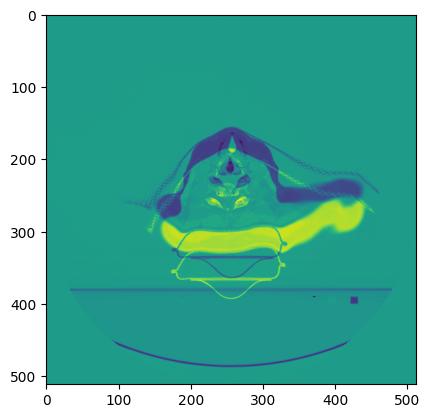

In [32]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
fixed_CT_array = sitk.GetArrayFromImage(fixed_CT.image)
moving_CT_array = sitk.GetArrayFromImage(moving_CT.image)
plt.imshow((moving_CT_array - fixed_CT_array)[70])

In [35]:
file_path = "/home/shahpouriz/Data/DBP_CTs/DBP_OP070_case_data.json"

with open(file_path, 'r') as file:
    case_data = json.load(file)


for exam_name, exam in case_data['examinations'].items():

    if len(exam['FoR_registrations']):
        original_FoR_registration = case_data['examinations'][exam_name]['FoR_registrations'][0]
        if type(original_FoR_registration['from_examination_name']) == list:
            original_FoR_registration['from_examination_name'] = exam_name
        if type(original_FoR_registration['to_examination_name']) == list:
            if plan['planning_examination']['name'] in original_FoR_registration['to_examination_name']:
                original_FoR_registration['to_examination_name'] = name_fixed_CT
            else:
                original_FoR_registration['to_examination_name'] = original_FoR_registration['to_examination_name'][0]
    elif exam_name in case_data['examinations'][name_fixed_CT]['FoR_registrations'][0]['to_examination_name']:
        original_FoR_registration = case_data['examinations'][name_fixed_CT]['FoR_registrations'][0]
        if type(original_FoR_registration['to_examination_name']) == list:
            original_FoR_registration['from_examination_name'] = exam_name
        if type(original_FoR_registration['from_examination_name']) == list:
            original_FoR_registration['to_examination_name'] = name_fixed_CT


pCTp0 {'name': 'pCTp0', 'fraction': 0, 'patient_position': 'HFS', 'equipment_info': {'modality': 'CT', 'frame_of_reference': '1.2.752.243.1.1.20240318152951464.8940.47105', 'imaging_system_reference': {'ImagingSystemName': 'CTAWP95434', 'CommissioningTime': '23-1-2018 22:45:20'}}, 'ROI_contours': {'external': ['External'], 'targets': ['PTV_7000', 'PTV_5425', 'CTV_5425', 'CTV_7000', 'PTV_7000_eval', 'PTV_5425_eval', 'CTV_5425+1mm', 'CTV_7000+1mm'], 'OARs': ['BODY', 'Eye_Post_L', 'Eye_Post_R', 'Eye_Ant_L', 'Eye_Ant_R', 'Brain', 'BrainStem', 'BuccalMucosa_L', 'BuccalMucosa_R', 'Cerebellum', 'Cerebrum', 'Cochlea_L', 'Cochlea_R', 'Crico', 'OralCavity_Ext', 'PCM_Inf', 'PCM_Med', 'PCM_Sup', 'Parotid_L', 'Parotid_R', 'SpinalCord', 'Submandibular_L', 'Submandibular_R', 'Supraglottic', 'BaseOfTongue'], 'material_overrides': []}, 'FoR_registrations': [], 'registration_to_planning_examinations': {'A1FHH': {'from_examination_name': 'pCTp0', 'to_examination_name': 'pCTf0', 'rigid_transformation_matr

IndexError: list index out of range

In [ ]:
import random            
for i in range(number_of_new_cases):
    translations = {axis: (2 * random.random() - 1) * max_translation if axis in ['x', 'y', 'z'] else 0 for axis in ['roll', 'pitch', 'yaw']}

    opt_case = copy.deepcopy(original_opt_case)

    opt_case['initial_coordinate']['x'] = translations['x']
    opt_case['initial_coordinate']['y'] = translations['y']
    opt_case['initial_coordinate']['z'] = translations['z']